<a href="https://colab.research.google.com/github/iamharkirat/BMI598/blob/main/p6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import pathlib
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

Seed = 10
tf.random.set_seed(Seed)
np.random.seed(Seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 bach_midi   bmi598  'Colab Notebooks'	'ML Projects'   test.ipynb


In [33]:
# Define the path to the directory where the dataset is stored
DATASET_PATH = 'data'

# Define the path to the zip file containing the dataset
ZIP_FILE_PATH = 'mini_speech_commands.zip'

# Convert the dataset path to a pathlib.Path object for easy path manipulation
Data_Dir = pathlib.Path(DATASET_PATH)

# Check if the dataset directory exists; if not, extract the zip file
if not Data_Dir.exists():
    # Open the zip file in read mode
    with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as ZIP:
        # Extract all contents of the zip file into the dataset directory
        ZIP.extractall(DATASET_PATH)

# Generate a list of subdirectories in the dataset directory
Sub_Dir = [item.name for item in Data_Dir.glob('*') if item.is_dir()]

# Filter out any system directories like '_MACOSX' that might be in the dataset directory
Sub_Dir = [Directory for Directory in Sub_Dir if Directory not in ['_MACOSX']]


In [35]:
# Check if there are any subdirectories in the dataset directory
if Sub_Dir:
    # If there are, select the first subdirectory and construct its full path
    Commands_Dir = os.path.join(Data_Dir, Sub_Dir[1])

    # Create a list of command names by iterating over the contents of the first subdirectory,
    # and selecting only those that are directories themselves
    Commands = [item.name for item in pathlib.Path(Commands_Dir).glob('*') if item.is_dir()]
else:
    # If there are no subdirectories, set 'Commands' to an empty list
    Commands = []

# Print the list of command names found in the first subdirectory
print("Commands: ", Commands)


Commands:  ['none', 'left', 'no', 'up', 'down', 'go', 'only', 'stop', 'right', 'all', 'never', 'yes', 'must']


In [36]:
# Create training and validation datasets from the audio files in the directory
train_data, val_data = tf.keras.utils.audio_dataset_from_directory(
    directory = Commands_Dir,      # Specify the directory containing the audio data
    batch_size = 64,               # Set the batch size for the dataset
    validation_split = 0.2,        # Allocate 20% of the data for validation
    seed = 10,                     # Seed for shuffling and transformations
    output_sequence_length = 16000,# Set the sequence length of the output audio files
    subset = 'both')               # Create both training and validation datasets

# Extract the class names (labels) from the training dataset
label_names = np.array(train_data.class_names)

# Print the names of the labels found in the dataset
print()
print("label names: ", label_names)


Found 8300 files belonging to 13 classes.
Using 6640 files for training.
Using 1660 files for validation.

label names:  ['all' 'down' 'go' 'left' 'must' 'never' 'no' 'none' 'only' 'right' 'stop'
 'up' 'yes']


In [37]:
train_data.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [38]:
# Define a function to 'squeeze' or remove a dimension from the audio data
def Squeeze(audio, labels):
    # Squeeze the audio data to remove the last dimension
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

# Apply the 'Squeeze' function to each element in the training dataset
# This is done using the 'map' method, which applies a specified function to each element in the dataset
train_data = train_data.map(Squeeze, tf.data.AUTOTUNE)

# Similarly, apply the 'Squeeze' function to the validation dataset
val_data = val_data.map(Squeeze, tf.data.AUTOTUNE)


In [39]:
# Split the validation dataset into two parts: one for testing and the other for validation
# 'shard' method divides the dataset into a specified number of shards

# Create a test dataset by taking the first shard (index 0) from the validation dataset
# This effectively splits the validation dataset into two equal parts
test_data = val_data.shard(num_shards=2, index=0)

# Update the validation dataset to only include the second shard (index 1)
# Now, the validation dataset is the other half of the original validation data
val_data = val_data.shard(num_shards=2, index=1)


In [40]:
# Iterate over the training dataset, but only take the first batch of data
for example_audio, example_labels in train_data.take(1):
    # Print the shape of the audio data in the batch
    # This shows the dimensions of the audio data, such as number of samples and their length
    print(example_audio.shape)

    # Print the shape of the labels associated with the audio data
    # This indicates the dimensions of the label data, like the number of samples
    print(example_labels.shape)


(64, 16000)
(64,)


In [41]:
label_names[[1, 1, 3, 0]]

array(['down', 'down', 'left', 'all'], dtype='<U5')

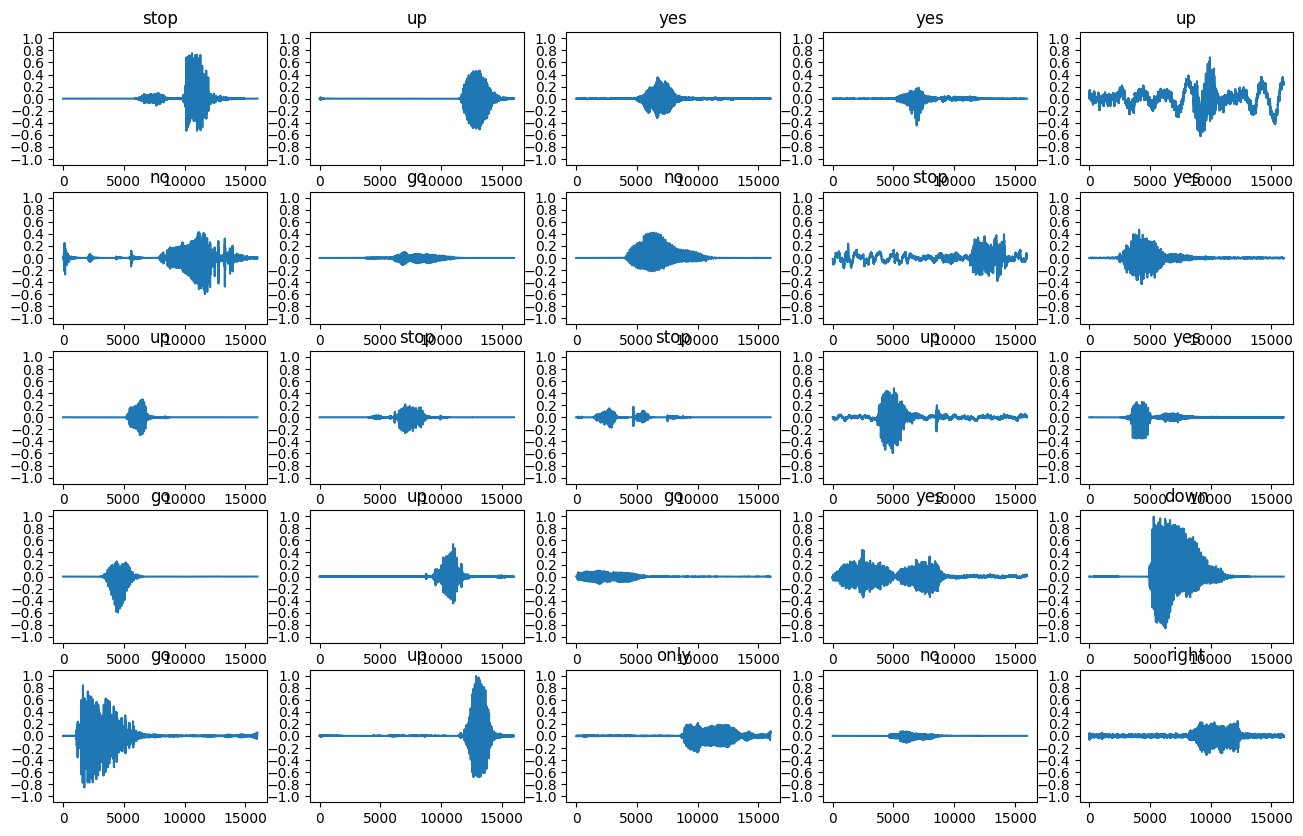

In [42]:
# Import the matplotlib.pyplot module for plotting
import matplotlib.pyplot as plt

# Set the size of the overall figure
plt.figure(figsize=(16, 10))

# Define the number of rows and columns for subplots
rows = 5
columns = 5

# Calculate the total number of subplots needed
n = rows * columns

# Loop through each subplot index
for i in range(n):
    # Create a subplot in the ith position
    plt.subplot(rows, columns, i + 1)

    # Extract the ith audio signal from the batch
    audio_signal = example_audio[i]

    # Plot the audio signal
    plt.plot(audio_signal)

    # Set the title of the subplot to the corresponding label name
    # 'example_labels[i]' gets the label index, and 'label_names[...]' gets the actual label name
    plt.title(label_names[example_labels[i]])

    # Set the y-axis ticks at regular intervals for uniformity
    plt.yticks(np.arange(-1.2, 1.2, 0.2))

    # Set the limits for the y-axis to keep all plots consistent
    plt.ylim([-1.1, 1.1])

# Show the plots
plt.show()


In [46]:
def get_spectrogram(waveform):
    # Compute the Short-Time Fourier Transform (STFT) of the waveform
    # 'frame_length' is the window length, 'frame_step' is the hopping length
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)

    # Take the absolute value of the STFT to get the magnitude spectrogram
    spectrogram = tf.abs(spectrogram)

    # Add a new axis to the spectrogram tensor to make it 3D
    # This is often required to match the input shape expected by CNNs
    spectrogram = spectrogram[..., tf.newaxis]

    return spectrogram


In [49]:
# Loop over the first three elements of the dataset
for i in range(3):
    # Retrieve the label name for the i-th audio sample
    label = label_names[example_labels[i]]

    # Get the waveform (audio data) for the i-th sample
    waveform = example_audio[i]

    # Generate a spectrogram from the waveform using the 'get_spectrogram' function
    spectrogram = get_spectrogram(waveform)

    # Print the label of the audio sample for identification
    print('Label: ', label)

    # Print the shape of the waveform to understand its size and structure
    print('Waveform Shape: ', waveform.shape)

    # Print the shape of the spectrogram to understand its size and structure
    print('Spectrogram Shape: ', spectrogram.shape)

    # Indicate that the next output will be an audio playback widget
    print('Audio Playback: ')

    # Use the display module to play the audio
    # The rate parameter sets the sampling rate for the playback
    display.display(display.Audio(waveform, rate=16000))


Label:  stop
Waveform Shape:  (16000,)
Spectrogram Shape:  (124, 129, 1)
Audio Playback: 


Label:  up
Waveform Shape:  (16000,)
Spectrogram Shape:  (124, 129, 1)
Audio Playback: 


Label:  yes
Waveform Shape:  (16000,)
Spectrogram Shape:  (124, 129, 1)
Audio Playback: 


In [50]:
def plot_spectogram(spectrogram, Axis):
    # Check if the spectrogram has more than two dimensions
    if len(spectrogram.shape) > 2:
        # Ensure that the spectrogram is exactly 3-dimensional
        assert len(spectrogram.shape) == 3
        # Remove the last dimension from the spectrogram
        spectrogram = np.squeeze(spectrogram, axis=-1)

    # Apply logarithmic scaling to the spectrogram's values
    # 'np.finfo(float).eps' is added to avoid log(0) which is undefined
    log_specifications = np.log(spectrogram.T + np.finfo(float).eps)

    # Get the height and width of the log-scaled spectrogram
    height = log_specifications.shape[0]
    width = log_specifications.shape[1]

    # Create an array of X values corresponding to the spectrogram's columns
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)

    # Create a range of Y values corresponding to the spectrogram's rows
    Y = range(height)

    # Plot the log-scaled spectrogram using 'pcolormesh'
    Axis.pcolormesh(X, Y, log_specifications)


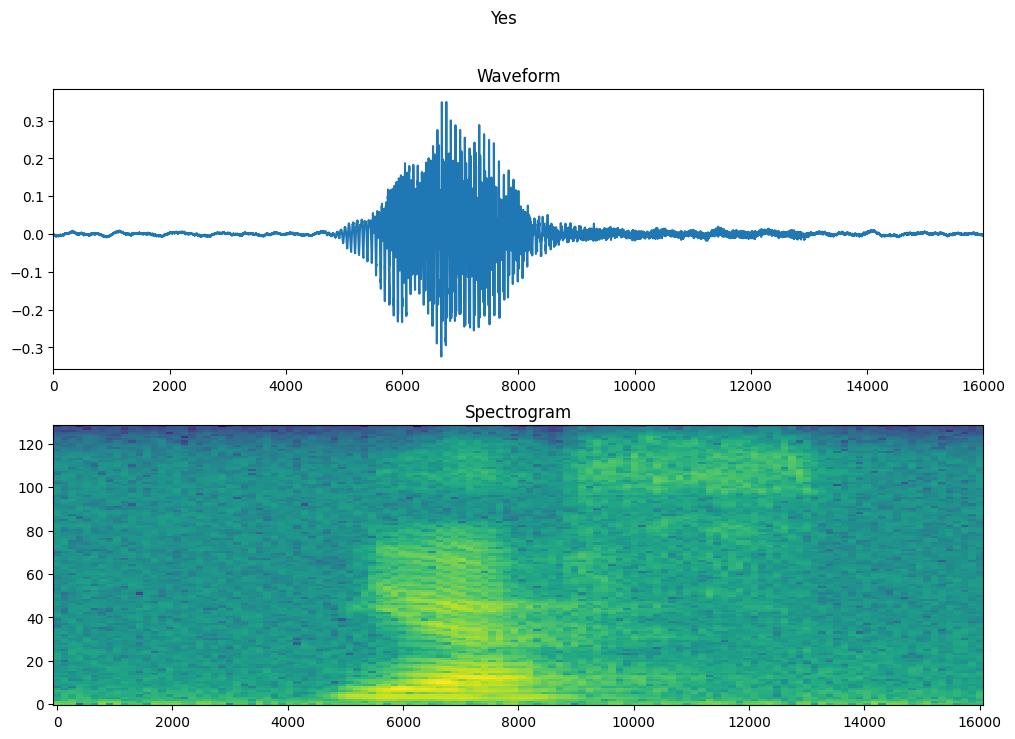

In [51]:
# Create a figure and a 2-row subplot layout, each row having one plot
fig, axes = plt.subplots(2, figsize=(12, 8))

# Define the timescale for the waveform; it should match the waveform's length
timescale = np.arange(waveform.shape[0])

# Plot the waveform on the first subplot
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')  # Set the title for the waveform plot
axes[0].set_xlim([0, 16000])   # Set the x-axis limit for the waveform plot

# Plot the spectrogram on the second subplot using the 'plot_spectogram' function
plot_spectogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')  # Set the title for the spectrogram plot

# Set a super title for the entire figure based on the label of the audio sample
plt.suptitle(label.title())

# Display the complete figure with both subplots
plt.show()


In [52]:
def make_spectogram_dataset(dataset):
    # Use the 'map' method to apply a transformation to each element in the dataset
    return dataset.map(
        # 'map_func' is a lambda function that processes each element (audio and label pair)
        # The function applies 'get_spectrogram' to the audio part of each element
        map_func=lambda audio, label: (get_spectrogram(audio), label),

        # Set 'num_parallel_calls' to 'tf.data.AUTOTUNE'
        # This allows TensorFlow to dynamically choose the number of parallel calls
        # based on available CPU, optimizing the data processing speed
        num_parallel_calls=tf.data.AUTOTUNE)


In [53]:
train_spectogram_dataset = make_spectogram_dataset(train_data)
val_spectogram_dataset = make_spectogram_dataset(val_data)
test_spectogram_dataset = make_spectogram_dataset(test_data)

In [54]:
for example_spectograms, example_spectogram_labels in train_spectogram_dataset.take(1):
    break

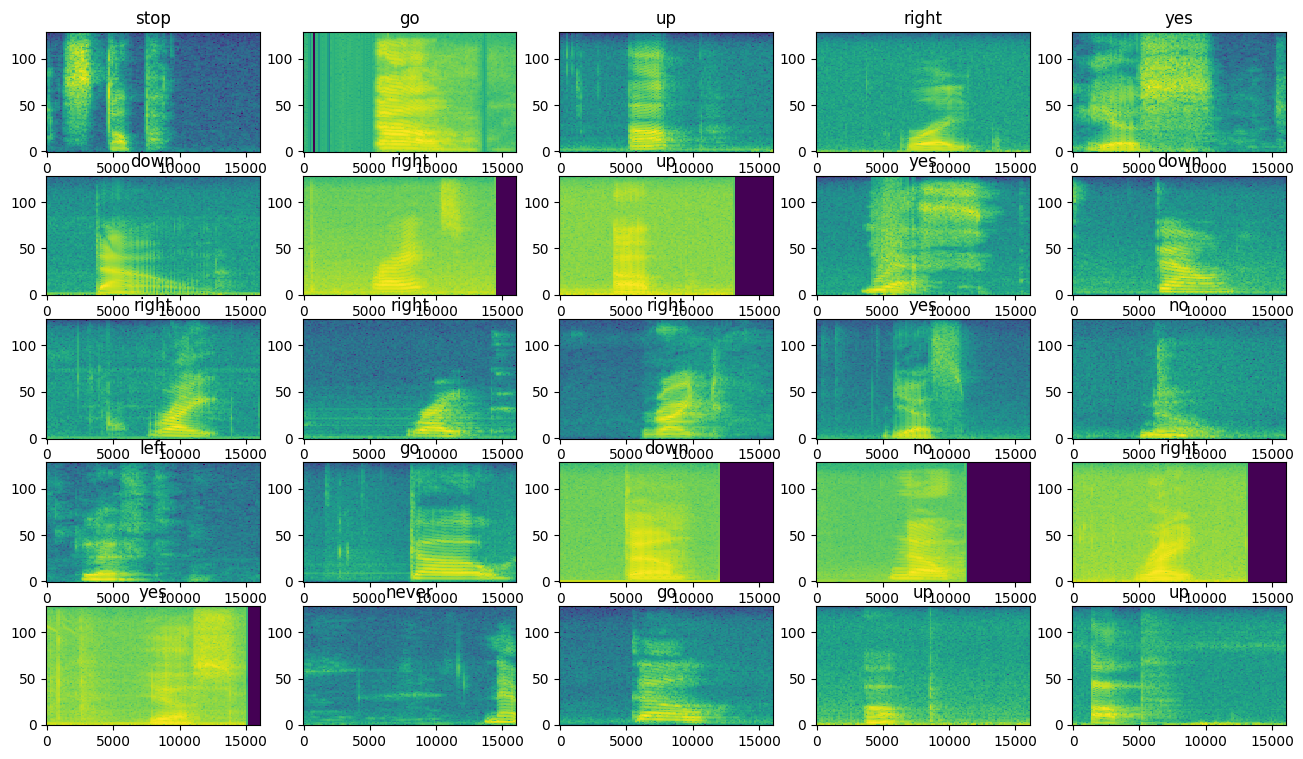

In [55]:
# Define the number of rows and columns for the grid of subplots
rows = 5
columns = 5

# Calculate the total number of plots needed
n = rows * columns

# Create a figure and a grid of subplots with the specified dimensions
fig, axes = plt.subplots(rows, columns, figsize=(16, 9))

# Loop through each position in the grid
for i in range(n):
    # Calculate the row and column index for the current subplot
    row = i // columns
    column = i % columns

    # Access the specific axis for the current subplot
    axis = axes[row][column]

    # Plot the spectrogram on this axis using the 'plot_spectogram' function
    plot_spectogram(example_spectograms[i].numpy(), axis)

    # Set the title for this subplot using the label of the corresponding spectrogram
    axis.set_title(label_names[example_spectogram_labels[i].numpy()])


In [56]:
test_spectogram_dataset = test_spectogram_dataset.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectogram_dataset = val_spectogram_dataset.cache().prefetch(tf.data.AUTOTUNE)
test_spectogram_dataset = test_spectogram_dataset.cache().prefetch(tf.data.AUTOTUNE)

In [58]:
# Extract the input shape from the example spectrograms
input_shape = example_spectograms.shape[1:]
print('Input shape: ', input_shape)

# Determine the number of labels in the dataset
number_of_labels = len(label_names)

# Create a normalization layer
Normalised_Layer = layers.Normalization()

# Adapt the normalization layer to the data
# This computes the mean and variance, and stores them in the layer
Normalised_Layer.adapt(data=train_spectogram_dataset.map(lambda spec, label: spec))

# Define the model using the Sequential API
model = models.Sequential([
    # Define the input layer with the shape of the spectrogram data
    layers.Input(shape=input_shape),

    # Resize the input images to the desired size for the model
    layers.Resizing(32, 32),

    # Add the normalization layer
    Normalised_Layer,

    # First convolutional layer with 32 filters and a kernel size of 3
    layers.Conv2D(32, 3, activation='relu'),

    # Second convolutional layer with 64 filters and a kernel size of 3
    layers.Conv2D(64, 3, activation='relu'),

    # Max pooling layer to reduce the spatial dimensions
    layers.MaxPooling2D(),

    # Dropout layer for regularization (reduces overfitting)
    layers.Dropout(0.25),

    # Flatten the output to make it suitable for the dense layer
    layers.Flatten(),

    # Dense layer with 64 units and ReLU activation
    layers.Dense(64, activation='relu'),

    # Another dropout layer for regularization
    layers.Dropout(0.5),

    # Output dense layer with a unit for each label
    layers.Dense(number_of_labels)
])

# Print the model summary to see the architecture and parameters
model.summary()


Input shape:  (124, 129, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)      

In [59]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy'],
)

In [60]:
# Define the number of epochs for training
EPOCHS = 10

# Train the model
history = model.fit(
    train_spectogram_dataset,     # Training dataset
    validation_data=val_spectogram_dataset, # Validation dataset for evaluating the model after each epoch
    epochs=EPOCHS,               # Number of training epochs
)

Epoch 1/10
104/104 [==============================] - 45s 406ms/step - loss: 2.1450 - accuracy: 0.2498 - val_loss: 1.6500 - val_accuracy: 0.4517
Epoch 2/10
104/104 [==============================] - 41s 386ms/step - loss: 1.6068 - accuracy: 0.4428 - val_loss: 1.2198 - val_accuracy: 0.6075
Epoch 3/10
104/104 [==============================] - 39s 367ms/step - loss: 1.2754 - accuracy: 0.5509 - val_loss: 1.0014 - val_accuracy: 0.6679
Epoch 4/10
104/104 [==============================] - 43s 401ms/step - loss: 1.1048 - accuracy: 0.6090 - val_loss: 0.8828 - val_accuracy: 0.7041
Epoch 5/10
104/104 [==============================] - 36s 333ms/step - loss: 0.9812 - accuracy: 0.6550 - val_loss: 0.8115 - val_accuracy: 0.7234
Epoch 6/10
104/104 [==============================] - 49s 466ms/step - loss: 0.8991 - accuracy: 0.6742 - val_loss: 0.7718 - val_accuracy: 0.7331
Epoch 7/10
104/104 [==============================] - 37s 350ms/step - loss: 0.8336 - accuracy: 0.6967 - val_loss: 0.6873 - val_ac

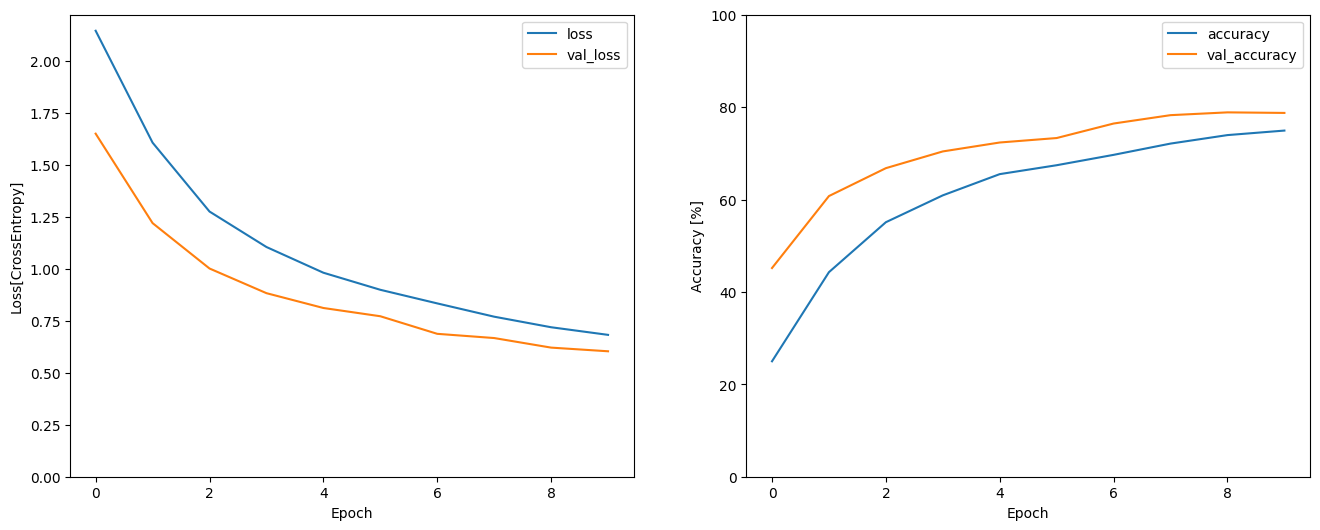

In [61]:
# Retrieve the training metrics from the history object
metrics = history.history

# Set up a figure with two subplots side-by-side
plt.figure(figsize=(16, 6))

# First subplot for loss
plt.subplot(1, 2, 1)
# Plot training and validation loss
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
# Add a legend to differentiate between training and validation loss
plt.legend(['loss', 'val_loss'])
# Set the y-axis limits to [0, maximum current limit]
plt.ylim([0, max(plt.ylim())])
# Label the x-axis as 'Epoch' and y-axis as 'Loss[CrossEntropy]'
plt.xlabel('Epoch')
plt.ylabel('Loss[CrossEntropy]')

# Second subplot for accuracy
plt.subplot(1, 2, 2)
# Plot training and validation accuracy, scaled to percentage
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
# Add a legend to differentiate between training and validation accuracy
plt.legend(['accuracy', 'val_accuracy'])
# Set the y-axis limits to [0, 100] for percentage
plt.ylim([0, 100])
# Label the x-axis as 'Epoch' and y-axis as 'Accuracy [%]'
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

# Display the plots
plt.show()


In [63]:
model.evaluate(test_spectogram_dataset, return_dict = True)

13/13 [==============================] - 8s 136ms/step - loss: 0.5971 - accuracy: 0.7897


{'loss': 0.5970889329910278, 'accuracy': 0.7896634340286255}

In [64]:
y_pred = model.predict(test_spectogram_dataset)

13/13 [==============================] - 1s 49ms/step


In [65]:
y_pred = tf.argmax(y_pred, axis = 1)

In [66]:
y_true = tf.concat(list(test_spectogram_dataset.map(lambda s,lab: lab)), axis=0)

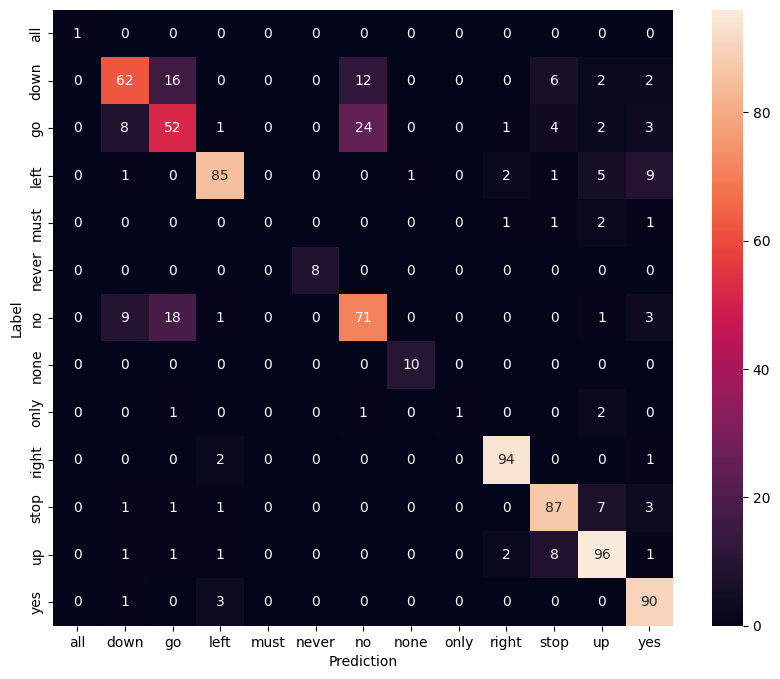

In [67]:
# Compute the confusion matrix using TensorFlow
Conf_Matrix = tf.math.confusion_matrix(y_true, y_pred)

# Set up the figure for plotting
plt.figure(figsize=(10, 8))

# Use seaborn's heatmap function to visualize the confusion matrix
sns.heatmap(Conf_Matrix,
            xticklabels=label_names,   # Set x-axis tick labels as label names (predictions)
            yticklabels=label_names,   # Set y-axis tick labels as label names (true labels)
            annot=True,                # Annotate each cell with the numeric value
            fmt='g')                   # Use a general format for the annotations

# Set the label for the x-axis
plt.xlabel('Prediction')

# Set the label for the y-axis
plt.ylabel('Label')

# Display the heatmap
plt.show()


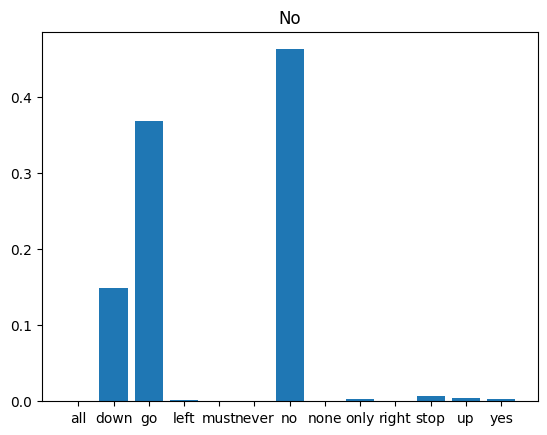

In [68]:
# File path for the audio file
X = '/content/data/mini_speech_commands/no/01bb6a2a_nohash_0.wav'

# Read the audio file
X = tf.io.read_file(str(X))

# Decode the audio file to get the waveform and sample rate
# 'desired_channels=1' ensures the audio is mono, 'desired_samples=16000' resamples the audio to 16kHz if necessary
X, sample_rate = tf.audio.decode_wav(X, desired_channels=1, desired_samples=16000)

# Remove the last dimension from the waveform
X = tf.squeeze(X, axis=-1)

# Copy the waveform for later playback
waveform = X

# Convert the waveform to a spectrogram
X = get_spectrogram(X)

# Add a batch dimension to the spectrogram for model prediction
X = X[tf.newaxis, ...]

# Make a prediction using the model
pred = model(X)

# Define the class labels
X_Labels = ['all', 'down', 'go', 'left', 'must', 'never', 'no', 'none', 'only', 'right', 'stop', 'up', 'yes']

# Plot a bar graph of the prediction probabilities
# Apply softmax to the predictions to get probabilities
plt.bar(X_Labels, tf.nn.softmax(pred[0]))
# Set the title of the plot
plt.title('No')

# Show the plot
plt.show()

# Use IPython's display module to play back the audio
display.display(display.Audio(waveform, rate=16000))


In [69]:
class ExportModel(tf.Module):
    def __init__(self, Model):
        # Initialize the ExportModel instance with an existing model
        self.Model = Model

    # Define a TensorFlow function with the specified input signature
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 16000], dtype=tf.float32)])
    def __call__(self, X):
        # If the input is a string (assumed to be a file path), read and process the audio file
        if X.dtype == tf.string:
            X = tf.io.read_file(X)
            X, _ = tf.audio.decode_wav(X, desired_channels=1, desired_samples=16000)
            X = tf.squeeze(X, axis=-1)
            X = X[tf.newaxis, :]

        # Convert the waveform to a spectrogram
        X = get_spectrogram(X)

        # Get the model's predictions; 'training=False' ensures the model runs in inference mode
        Result = self.Model(X, training=False)

        # Determine the class IDs from the predictions
        Class_IDs = tf.argmax(Result, axis=-1)

        # Map class IDs to their respective names
        Class_Names = tf.gather(label_names, Class_IDs)

        # Return the predictions, class IDs, and class names in a dictionary
        return {'Predictions': Result,
                'Class IDs': Class_IDs,
                'Class Names': Class_Names}


In [70]:
Export = ExportModel(model)
tf.saved_model.save(Export, "Saved", signatures={"serving_default": Export.__call__})

In [71]:
tf.saved_model.save(Export, 'Saved')
Imported = tf.saved_model.load('Saved')
Imported(waveform[tf.newaxis, :])

{'Predictions': <tf.Tensor: shape=(1, 13), dtype=float32, numpy=
 array([[-5.748273  ,  2.8122818 ,  3.7162356 , -1.6407441 , -4.505141  ,
         -4.3162284 ,  3.9457512 , -4.1639185 , -1.3370925 , -2.4141967 ,
         -0.19558889, -0.6911377 , -1.0747665 ]], dtype=float32)>,
 'Class Names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>,
 'Class IDs': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([6])>}

In [72]:
# Create a TFLiteConverter object from a SavedModel directory
Converter = tf.compat.v1.lite.TFLiteConverter.from_saved_model('/content/Saved')

# Convert the model to the TFLite format
TFLite_Model = Converter.convert()

# Write the converted TFLite model to a file
with tf.io.gfile.GFile('Model.tflite', 'wb') as f:
    f.write(TFLite_Model)


Instructions for updating:
Use `tf.saved_model.load` instead.
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.function' or '@defun' to decorate the function.
Use '@tf.functio

In [73]:
from google.colab import files
files.download('/content/Model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
!apt-get install xxd
!xxd -i Model.tflite > Model_data.cpp

files.download('Model_data.cpp')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xxd is already the newest version (2:8.2.3995-1ubuntu2.13).
xxd set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [75]:
# Create a TFLiteConverter object from a SavedModel directory
converter = tf.lite.TFLiteConverter.from_saved_model('Saved')

# Enable the experimental new converter
converter.experimental_new_converter = True

# Set the target specifications for the converter
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops that are built into the interpreter
    tf.lite.OpsSet.SELECT_TF_OPS,    # Enable TensorFlow ops that are not built into the interpreter but are supported through the TensorFlow Select mechanism
]

# Convert the model to the TensorFlow Lite format
quantized_tflite_model = converter.convert()


In [76]:
with tf.io.gfile.GFile('Quantized_Model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)


In [77]:
from google.colab import files
files.download('Quantized_Model.tflite')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [78]:
!xxd -i Quantized_Model.tflite > Quantized_Model_data.cpp

In [79]:
from google.colab import files
files.download('Quantized_Model_data.cpp')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>